# Introduction
Previously, we conducted a preliminary EDA and assessed some naive machine learning models. This notebook will deal with some feature engineering to see if we can improve model run time and fit. 

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile 
from zipfile import ZipFile 



# opening the zip file in READ mode 
file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    
    
# import
df_zip = zipfile.ZipFile(file_name)
train = pd.read_csv(df_zip.open('train.csv'))
test = pd.read_csv(df_zip.open('test.csv'))
sample_submission = pd.read_csv(df_zip.open('sample_submission.csv')) 

File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


# EDA

## Sample EDA

Since the dataset is extremely large (11~ million rows), let's do some preliminary EDA on a subset. 

In [4]:


import random

n = len(train) # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))   
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows = skip)
train_sample


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,12,Male,36,1,28.0,0,1-2 Year,Yes,38104.0,26.0,203,0
1,32,Male,43,1,10.0,1,1-2 Year,No,18361.0,152.0,260,0
2,33,Female,20,1,8.0,0,< 1 Year,Yes,48752.0,160.0,151,0
3,37,Male,25,1,26.0,1,< 1 Year,No,2630.0,152.0,290,0
4,41,Female,63,1,41.0,0,1-2 Year,Yes,30173.0,124.0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504747,Female,66,1,46.0,1,1-2 Year,No,41293.0,11.0,158,0
1150475,11504748,Male,63,1,19.0,0,1-2 Year,Yes,34870.0,26.0,288,0
1150476,11504752,Male,49,1,46.0,1,1-2 Year,No,24187.0,26.0,195,0
1150477,11504768,Female,22,1,8.0,0,< 1 Year,Yes,30106.0,152.0,254,0



## X, y split

In [5]:

from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

# drop id columns
train.drop(["id"],axis = 1, inplace = True)

# features
x_train = train.drop(["Response"], axis = 1)
# label
y_train = train.Response

X_data, X_valid, y_data,y_valid =  train_test_split(x_train, y_train, test_size=0.25,  random_state=42, stratify = y_train)

# sample split
train_sample.drop(["id"],axis = 1, inplace = True)

# features
xs_train = train_sample.drop(["Response"], axis = 1)
# label
ys_train = train_sample.Response

Xs_data, Xs_valid, ys_data,ys_valid =  train_test_split(xs_train, ys_train, test_size=0.25,  random_state=42, stratify = ys_train)


## Univariate visualization

### Numerical 

#### Descriptives

In [41]:
numeric_df = xs_train[["Age", "Annual_Premium", "Vintage"]]
stats = numeric_df.describe().loc[["mean", "std", "min", "max"]]
stats.loc['var'] = numeric_df.var().tolist()
stats.loc['skew'] = numeric_df.skew().tolist()
stats.loc['kurt'] = numeric_df.kurtosis().tolist()
stats.loc['mode'] = numeric_df.mode().melt().value.tolist()

In [43]:
pd.options.display.float_format = '{:.0f}'.format
stats

,Age,Annual_Premium,Vintage
mean,38,30448,164
std,15,16361,80
min,20,2630,10
max,85,540165,299
var,225,267681220,6394
skew,1,1,-0
kurt,-1,18,-1
mode,24,2630,187


#### Feature engineering

In [7]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pt = PowerTransformer(method='yeo-johnson', standardize=True).set_output(transform="pandas")
std = StandardScaler().set_output(transform="pandas")
minmax = MinMaxScaler().set_output(transform="pandas")

pt_df = pt.fit_transform(numeric_df)
std_df = std.fit_transform(numeric_df)
minmax_df = minmax.fit_transform(numeric_df)
log_df = np.log(numeric_df)


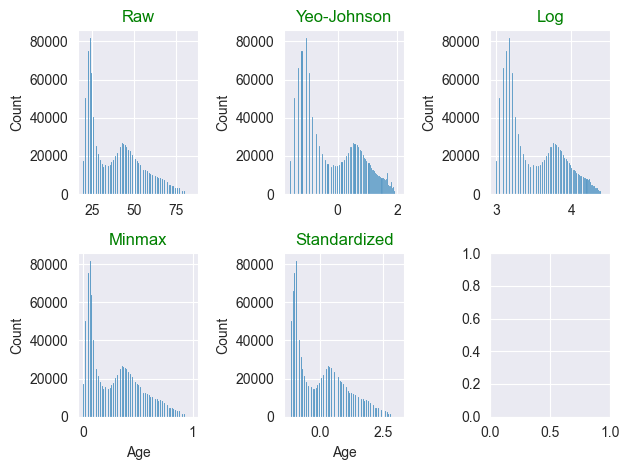

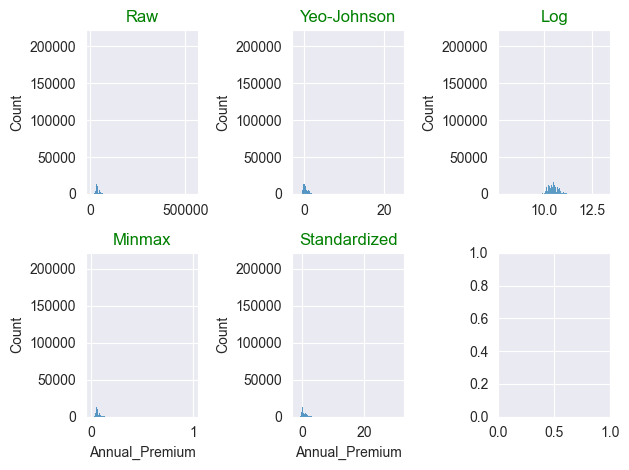

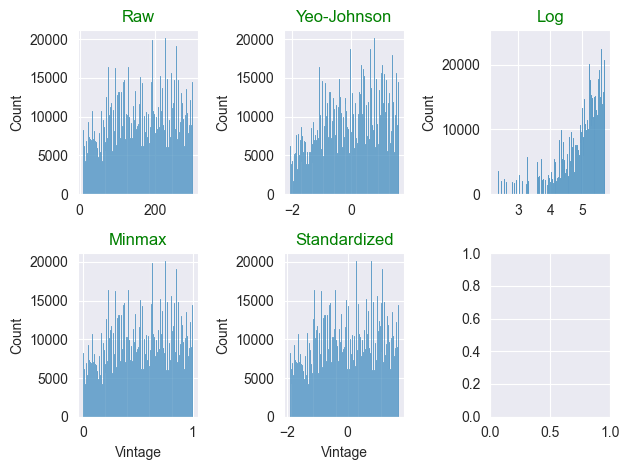

In [16]:

for col in numeric_df.columns:
    
    fig, ax = plt.subplots(2, 3)
    sns.histplot(ax = ax[0,0], data = numeric_df, x=col, label  = "Raw")
    sns.histplot(ax = ax[0,1], data = pt_df, x=col,label  = "Yeo-Johnson")
    sns.histplot(ax = ax[0,2], data = log_df, x=col, label  = "Log")
    sns.histplot(ax = ax[1,0], data = minmax_df, x=col,label  = "Minmax")
    sns.histplot(ax = ax[1,1], data = std_df, x=col, label  = "Standardized")
    ax[0,0].set_title("Raw", fontdict = {'color': 'green'})
    ax[0,1].set_title("Yeo-Johnson", fontdict = {'color': 'green'})
    ax[0,2].set_title("Log", fontdict = {'color': 'green'})
    ax[1,0].set_title("Minmax", fontdict = {'color': 'green'})
    ax[1,1].set_title("Standardized", fontdict = {'color': 'green'})
    ax[0,0].set_xlabel(None)
    ax[0,1].set_xlabel(None)
    ax[0,2].set_xlabel(None)
    plt.tight_layout()
    plt.show()
    plt.close("all")



Age is bimodal and Annual Premium clearly still has something more going on.

Not only is the graph stretched out to the right (high values), it's stretched out to the top. This means there's a very high count of a specific value(s), but since it only occurs for those few value(s), we don't see it at all since it would be just a single thin line. We need to graph this as separate ranges to understand what's going on.

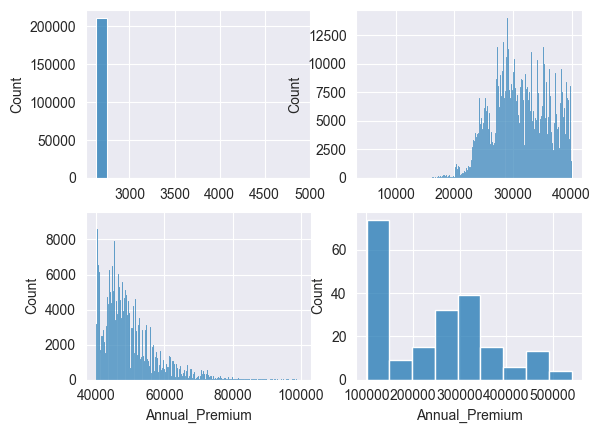

In [57]:
fig, ax = plt.subplots(2, 2)
sns.histplot(ax = ax[0,0], data = numeric_df[numeric_df["Annual_Premium"] < 5000], x="Annual_Premium")
sns.histplot(ax = ax[0,1], data = numeric_df[(numeric_df["Annual_Premium"] >= 5000) & (numeric_df["Annual_Premium"] < 40000) ], x="Annual_Premium")
sns.histplot(ax = ax[1,0], data = numeric_df[(numeric_df["Annual_Premium"] >= 40000) & (numeric_df["Annual_Premium"] < 100000) ], x="Annual_Premium")
sns.histplot(ax = ax[1,1], data = numeric_df[(numeric_df["Annual_Premium"] >= 100000)  ], x="Annual_Premium")
ax[0, 0].set_xlabel(None)
ax[0, 1].set_xlabel(None)
plt.show()
plt.close("all")

Most of the values occur below Annual Premiums of 5000 (specifically, we know the mode is 2630). This is likely the default value for Annual Premiums, perhaps when customers sign on. Although there are extreme values to the right, they taper off and appear to be reasonable to the overall distribution of Annual Premiums.